In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import csv
import glob
import pandas as pd
import re

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator

from tensorflow.keras.models import load_model

from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_hub as hub

from tqdm import tqdm


# Preparation and Preprocessing

## Creating Images


In [2]:
file_folder = "data/images_train"
label_file = "data/classes.csv"

labels_dict = {}
image_files = sorted(glob.glob(os.path.join(file_folder, "**", "*.png"), recursive=True))

label_df = pd.read_csv(label_file, index_col='file_id')

In [3]:
label_df['cell_line'] = [label.replace(' ', '_') for label in list(label_df['cell_line'])]
label_df.insert(1,'image_channels', len(label_df) * [[]])

In [4]:
for image in image_files:
    cell_id = int(re.search('0*([0-9]+)_', image)[1])
    label_df['image_channels'][cell_id] = label_df['image_channels'][cell_id] + [image]

In [5]:
label_df

,cell_line,image_channels
file_id,,
1,MCF7,"[data/images_train/00001_blue.png, data/images..."
2,RT4,"[data/images_train/00002_blue.png, data/images..."
3,U-2_OS,"[data/images_train/00003_blue.png, data/images..."
4,RT4,"[data/images_train/00004_blue.png, data/images..."
5,A549,"[data/images_train/00005_blue.png, data/images..."
...,...,...
9628,PC-3,"[data/images_train/09628_blue.png, data/images..."
9629,HEK_293,"[data/images_train/09629_blue.png, data/images..."
9630,RT4,"[data/images_train/09630_blue.png, data/images..."


In [6]:
LABELS = set(label_df['cell_line'])

skip this if the images folder with the corresponding images already exists

In [7]:
os.mkdir('data/images')
for label in LABELS:
    folder_path = f'data/images/{label}'
    os.mkdir(folder_path)

In [8]:
label_df

,cell_line,image_channels
file_id,,
1,MCF7,"[data/images_train/00001_blue.png, data/images..."
2,RT4,"[data/images_train/00002_blue.png, data/images..."
3,U-2_OS,"[data/images_train/00003_blue.png, data/images..."
4,RT4,"[data/images_train/00004_blue.png, data/images..."
5,A549,"[data/images_train/00005_blue.png, data/images..."
...,...,...
9628,PC-3,"[data/images_train/09628_blue.png, data/images..."
9629,HEK_293,"[data/images_train/09629_blue.png, data/images..."
9630,RT4,"[data/images_train/09630_blue.png, data/images..."


In [9]:
n = len(label_df)
for row in label_df.itertuples():
    cell_id = row[0]
    label = row[1]
    blue_channel = Image.open(row[2][0])
    red_channel = Image.open(row[2][1])
    green_channel = Image.open(row[2][2])
    rgb_image = Image.merge('RGB', (red_channel, green_channel, blue_channel))
    folder_path = f'data/images/{label}/{cell_id}.png'
    rgb_image.save(folder_path)
    print(f'{cell_id} of {n} done', end='\r')

## Split data into training and validation

In [ ]:
image_path = 'data/images/'

random_seed = 42
img_size = 299
batch_size = 32

# 80% Train, 10% Validation, 10% Test
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# train dataset (80%)
train = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=val_ratio + test_ratio,
    subset="training",
    seed=random_seed,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode="categorical"
)

# validation dataset (20%) -> split into test (10%) and validation (10%)
val = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=val_ratio + test_ratio,
    subset="validation",
    seed=random_seed,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode="categorical"
)

val_batches = tf.data.experimental.cardinality(val).numpy()
test_size = val_batches // 2

test = val.take(test_size) 
val = val.skip(test_size)

print(f"Train batches: {tf.data.experimental.cardinality(train).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test).numpy()}")


Found 9632 files belonging to 9 classes.
Using 7706 files for training.
Found 9632 files belonging to 9 classes.
Using 1926 files for validation.
Train batches: 241
Validation batches: 31
Test batches: 30


## Looking into the data

In [12]:
class_names = train.class_names


2025-03-06 11:41:31.143777: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


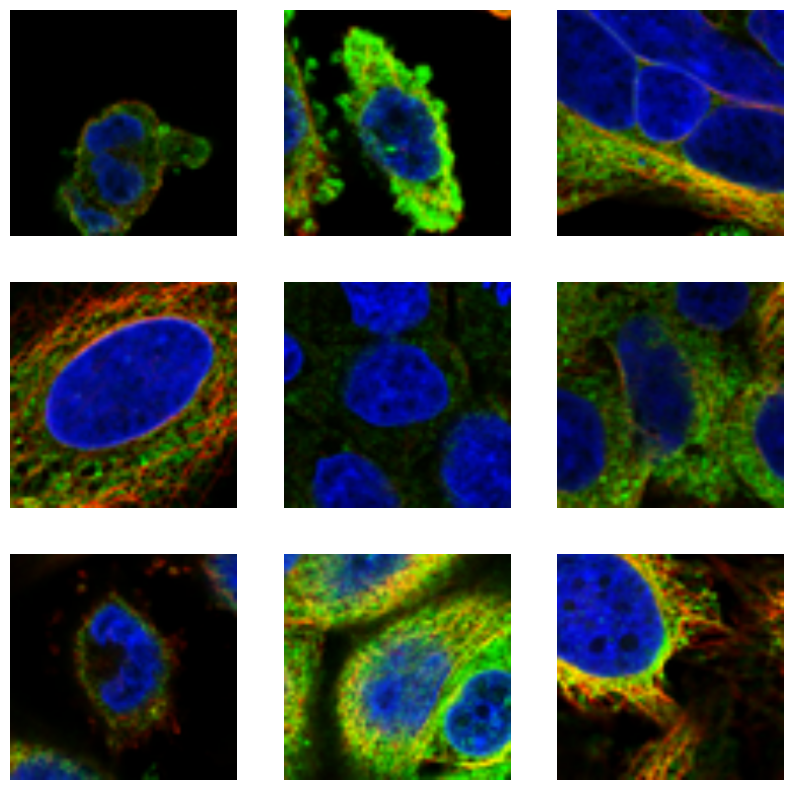

In [13]:
plt.figure(figsize=(10, 10))
for images, label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

check whether there is simple correlation between labels, and coloring of the picture.

In [14]:
red = []
blue = []
green = []
labels = []

In [15]:

for images, label in train.take(10):
    for image in images:
        red.append(np.array(image[:,:,0]).sum())
        blue.append(np.array(image[:,:,1]).sum())
        green.append(np.array(image[:,:,2]).sum())

        labels.append(label)

2025-03-06 11:41:33.909918: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
len(red)

320

(array([18., 70., 83., 60., 44., 25., 10.,  7.,  2.,  1.]),
 array([  56031.5   ,  644597.4375, 1233163.375 , 1821729.25  ,
        2410295.25  , 2998861.25  , 3587427.    , 4175993.    ,
        4764559.    , 5353125.    , 5941691.    ]),
 <BarContainer object of 10 artists>)

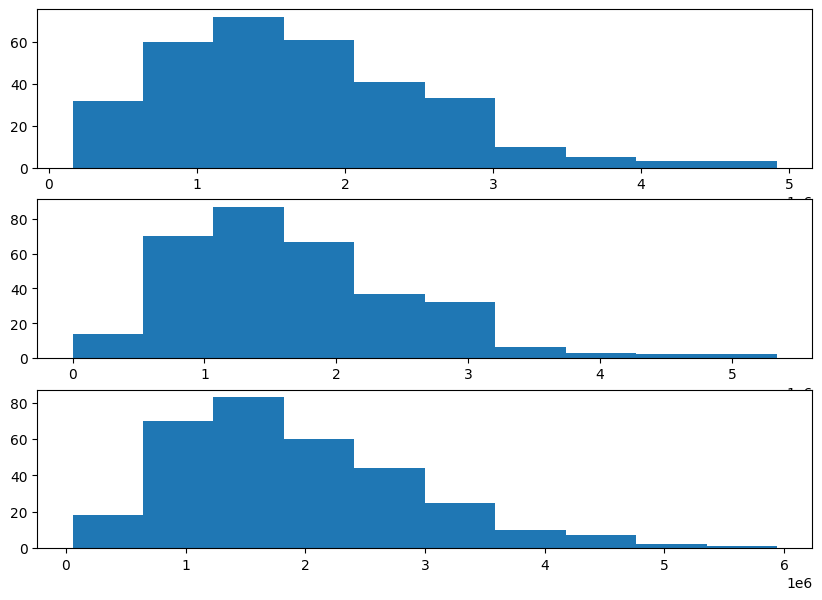

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 7))
ax[0].hist(red)
ax[1].hist(green)
ax[2].hist(blue)

In [20]:
colors = plt.get_cmap('tab10').colors[:len(LABELS)]
COLOR_DICT = dict(zip(range(len(LABELS)), colors))

In [25]:
coloring = [COLOR_DICT[np.argmax(label)] for label in labels]

In [26]:
len(coloring)

320

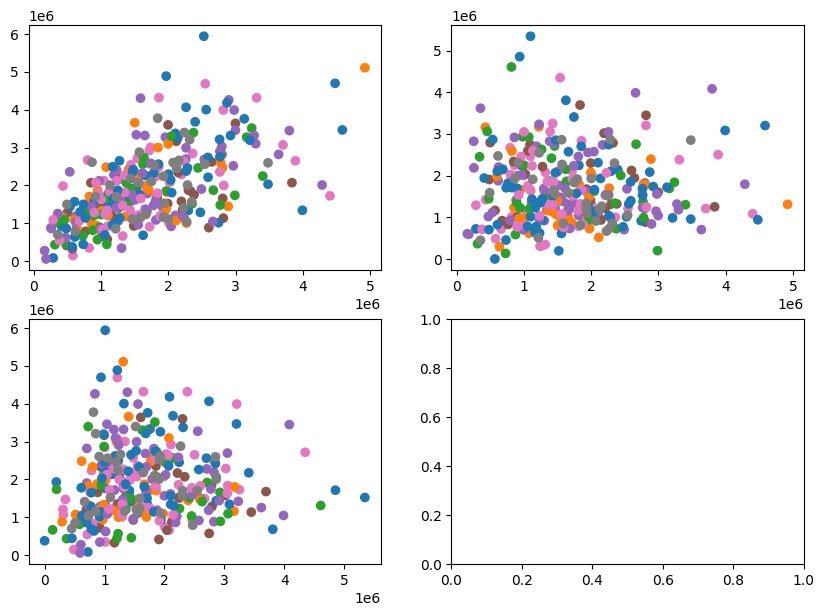

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
ax[0,0].scatter(red, blue, c=coloring)
ax[0,1].scatter(red, green, c=coloring)
ax[1,0].scatter(green, blue, c=coloring)


no easy seperation based only on the color, that occurs the most.

### look at distribution of classes

In [28]:
all_labels = list(label_df['cell_line'])

In [31]:
abs_distribution = {}
rel_distribution = {}
for label in LABELS:
    abs_distribution[label] = all_labels.count(label) 
    rel_distribution[label] = all_labels.count(label) / len(all_labels)

<BarContainer object of 9 artists>

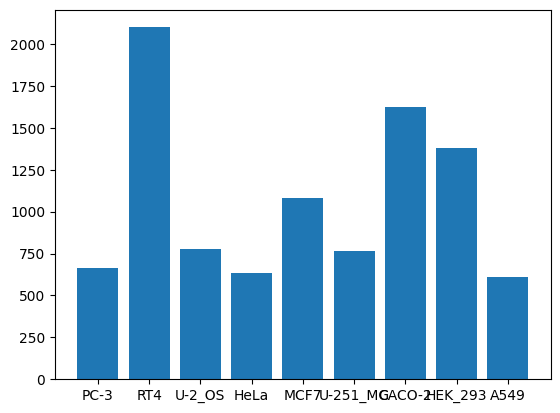

In [32]:
plt.bar(abs_distribution.keys(), abs_distribution.values())


{'PC-3': 0.06883305647840532, 'RT4': 0.2180232558139535, 'U-2_OS': 0.0804609634551495, 'HeLa': 0.06561461794019934, 'MCF7': 0.11233388704318936, 'U-251_MG': 0.07973421926910298, 'CACO-2': 0.168812292358804, 'HEK_293': 0.14306478405315615, 'A549': 0.06312292358803986}


<BarContainer object of 9 artists>

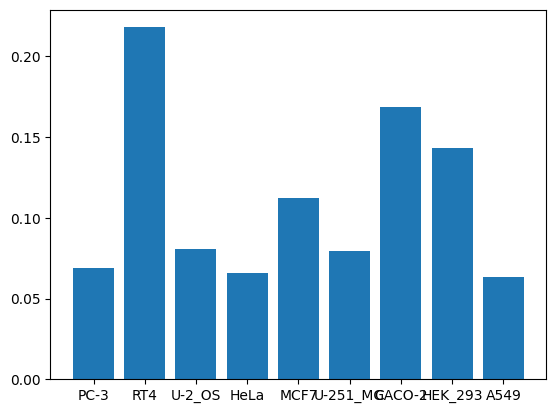

In [33]:
print(rel_distribution)
plt.bar(rel_distribution.keys(), rel_distribution.values())

we see that we have one overrepresented class - RT4, with around 22% falling into this class.

# Model
## setting up model

In [35]:
from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator


In [41]:
input_size = 299
input_shape = (input_size, input_size, 3)
batch_size = 16

In [47]:
input_shape = (299, 299, 3)
num_classes = 9

#model = InceptRNV2()
        
    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
pre_trained_model = Xception(include_top=False, pooling='avg', input_shape=input_shape, weights = 'imagenet')
pre_trained_model.trainable = True
    
    # custom modifications on top of pre-trained model and fit
clf_model = tf.keras.models.Sequential()
clf_model.add(pre_trained_model)
clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])


## training

In [48]:
filepath = "models_xception/saved-model-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [49]:
history = clf_model.fit(train, epochs=5, validation_data=val, callbacks=callbacks_list, steps_per_epoch=len(train), initial_epoch=0)

Epoch 1/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6525 - loss: 0.9978 
Epoch 1: saving model to models_xception/saved-model-01-0.48.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 3299s 14s/step - accuracy: 0.6530 - loss: 0.9965 - val_accuracy: 0.4824 - val_loss: 2.1484
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8898 - loss: 0.3399 
Epoch 2: saving model to models_xception/saved-model-02-0.73.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 3460s 14s/step - accuracy: 0.8899 - loss: 0.3397 - val_accuracy: 0.7319 - val_loss: 1.3660
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9389 - loss: 0.1849 
Epoch 3: saving model to models_xception/saved-model-03-0.88.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 3039s 13s/step - accuracy: 0.9390 - loss: 0.1848 - val_accuracy: 0.8768 - val_loss: 0.4649
Epoch 4/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9594 - loss: 0.1271 
Epoch 4: saving model to models_xception/saved-model-04-0.86.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 2899s 12s/step - accuracy: 0.9594 - loss: 0.1271 - val_accuracy: 0.8561 - val_loss: 0.5265
Epoch 5/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9607 - loss: 0.1115 
Epoch 5: saving model to models_xception/saved-model-05-0.78.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 2882s 12s/step - accuracy: 0.9607 - loss: 0.1115 - val_accuracy: 0.7754 - val_loss: 0.9246
